#OBJECT DETECTION

Lucrezia Rossi 2122164  
Nemanja Ilic 2105693

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import cv2
import random
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torch.multiprocessing as mp
from torchvision import models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision import transforms
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import time
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch.optim as optim
from tqdm import tqdm
from PIL import Image
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Percorso del file ZIP
zip_file_path = '/content/drive/MyDrive/coco_reduced.zip'

# Contenuto del file ZIP
import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

# Controllo che i file siano stati estratti
import os
os.listdir('/content/')



['.config', 'drive', 'val2017', 'annotations', 'train2017', 'sample_data']

In [ ]:
#LOAD DATASET
from pycocotools.coco import COCO

path = "/content"  # Percorso corretto
annotations_path = os.path.join(path, "annotations")

train_images_path = os.path.join(path, "train2017")
val_images_path = os.path.join(path, "val2017")

# Load annotations
train_ann_file = os.path.join(annotations_path, "instances_train2017.json")
val_ann_file = os.path.join(annotations_path, "instances_val2017.json")

# Initialize COCO API for train and val sets
coco_train = COCO(train_ann_file)
coco_val = COCO(val_ann_file)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
train_img_ids = coco_train.getImgIds()
train_images = [coco_train.loadImgs(img_id)[0] for img_id in train_img_ids]

val_img_ids = coco_val.getImgIds()
val_images = [coco_val.loadImgs(img_id)[0] for img_id in val_img_ids]

print(int(len(train_images)))

5914


In [ ]:
random.shuffle(train_images)  # Shuffle to ensure randomness
split_ratio = 0.8  # 80% for train, 20% for test

split_idx = int(len(train_images) * split_ratio)
training_images = train_images[:split_idx]
test_images = train_images[split_idx:]

print(int(len(training_images)))
print(int(len(test_images)))

4731
1183


In [ ]:
# Train Set
train_set = [os.path.join(train_images_path, img["file_name"]) for img in training_images]

# Validation Set
val_set = [os.path.join(val_images_path, img["file_name"]) for img in val_images]

# Test Set
test_set = [os.path.join(train_images_path, img["file_name"]) for img in test_images]

In [ ]:
# Ottieni gli ID delle immagini di train
train_labels = {}
train_ids = [img["id"] for img in train_images]

for img_id in train_ids:
    ann_ids = coco_train.getAnnIds(imgIds=img_id)  # Prendi ID annotazioni
    anns = coco_train.loadAnns(ann_ids)  # Carica annotazioni

    # Salva le etichette delle classi (category_id)
    train_labels[img_id] = [ann['category_id'] for ann in anns]

In [ ]:
# Ottieni gli ID delle immagini di test
test_labels = {}
test_ids = [img["id"] for img in test_images]

for img_id in test_ids:
    ann_ids = coco_train.getAnnIds(imgIds=img_id)  # Prendi ID annotazioni
    anns = coco_train.loadAnns(ann_ids)  # Carica annotazioni

    # Salva le etichette delle classi (category_id)
    test_labels[img_id] = [ann['category_id'] for ann in anns]

In [ ]:
# Ottieni gli ID delle immagini di validation
val_labels = {}

for img_id in val_img_ids:
    ann_ids = coco_val.getAnnIds(imgIds=img_id)  # Prendi ID annotazioni
    anns = coco_val.loadAnns(ann_ids)  # Carica annotazioni

    # Salva le etichette delle classi (category_id)
    val_labels[img_id] = [ann['category_id'] for ann in anns]

In [ ]:
# Prendi alcuni ID di immagini a caso
sample_ids = random.sample(val_img_ids, 5)  # Prendi 5 immagini a caso

for img_id in sample_ids:
    print(f"Immagine ID: {img_id}")
    print(f"Etichette: {val_labels[img_id]}")
    print("-" * 30)


Immagine ID: 159684
Etichette: [7, 85]
------------------------------
Immagine ID: 331604
Etichette: [42, 1]
------------------------------
Immagine ID: 87742
Etichette: [86]
------------------------------
Immagine ID: 185950
Etichette: [1, 41]
------------------------------
Immagine ID: 144333
Etichette: [77, 2, 3, 3, 3, 1, 31, 3]
------------------------------


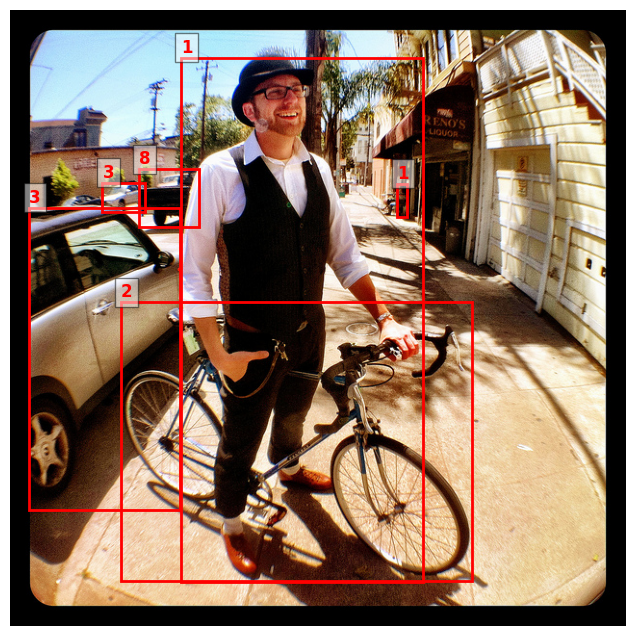

L'immagine contiene 6 oggetti.


In [ ]:
# Carica e mostra l'immagine
img_id = coco_train.getImgIds()[3]  # Prendi la quarta immagine (indice 3)

# Carica le informazioni dell'immagine
img_info = coco_train.loadImgs(img_id)[0]
img_path = os.path.join(train_images_path, img_info['file_name'])

img = Image.open(img_path)

# Mostra l'immagine con le bounding box
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img)

# Mostra anche alcune annotazioni (se necessario)
ann_ids = coco_train.getAnnIds(imgIds=img_id)
annotations = coco_train.loadAnns(ann_ids)

# Prendo i labels della mia immagine
labels = train_labels[img_id]

# Aggiungi bounding box e labels
for ann, label in zip(annotations, labels):
    bbox = ann['bbox']  # [x, y, width, height]
    x, y, w, h = bbox
    class_name = label

    # Aggiustare grafica bbox
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Aggiustare grafica labels
    ax.text(x, y - 5, class_name, color='red', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))

plt.axis('off')  # Disabilita l'asse
plt.show()

# Mostra il numero di oggetti nell'immagine
print(f"L'immagine contiene {len(annotations)} oggetti.")

In [ ]:
# Percorso al file delle annotazioni
annotations_path = '/content/annotations/instances_train2017.json'

# Carica il dataset COCO
coco = COCO(annotations_path)

# Ottieni tutte le categorie (classi) presenti
categories = coco.loadCats(coco.getCatIds())

# Stampa tutte le categorie e il numero totale di classi
print("Categorie:", [category['name'] for category in categories])
print("Numero di classi:", len(categories))

loading annotations into memory...
Done (t=0.85s)
creating index...
index created!
Categorie: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Numero di classi: 80


In [ ]:
# Funzione per convertire il formato dei dati dal tuo dataset a quello richiesto da Faster R-CNN
def collate_fn(batch):
    img, labels, bboxes = zip(*batch)
    images = [imgs.to(device) for imgs in img]

    targets = []
    for i in range(len(labels)):
        target = {
            "boxes": bboxes[i].to(device),
            "labels": labels[i].to(device)
        }
        targets.append(target)

    return images, targets

In [ ]:
# Definisci le trasformazioni
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ridimensiona le immagini a 128x128 (adatta alla tua architettura)
    transforms.ToTensor(),  # Converti in tensore
])

# Dataset personalizzato per COCO
class CocoDataset(Dataset):
    def __init__(self, coco, image_dir, target_size=(128, 128), transform=None):
        self.coco = coco
        self.image_dir = image_dir
        self.target_size = target_size
        self.transform = transform
        self.img_ids = coco.getImgIds()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        # Carica l'immagine
        img = Image.open(img_path).convert('RGB')
        orig_width, orig_height = img.size  # Dimensioni originali

        # Prendi le annotazioni per questa immagine
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        # Bounding box nel formato [x_min, y_min, x_max, y_max]
        bboxes = []
        labels = []

        for ann in annotations:
            x, y, w, h = ann["bbox"]

            # Riscalamento proporzionale
            scale_x = self.target_size[0] / orig_width
            scale_y = self.target_size[1] / orig_height

            x_min = x * scale_x
            y_min = y * scale_y
            x_max = (x + w) * scale_x
            y_max = (y + h) * scale_y

            bboxes.append([x_min, y_min, x_max, y_max])
            labels.append(ann["category_id"])  # Etichetta della classe

        # Converti labels e bboxes in tensori
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        img = img.resize(self.target_size, Image.BILINEAR)  # Riscalo l'immagine

        if self.transform:
            img = self.transform(img)

        return img, labels, bboxes  # Restituisce separatamente labels e bboxes

# Crea il dataset
train_dataset = CocoDataset(coco_train, train_images_path, target_size=(128, 128), transform=transform)
val_dataset = CocoDataset(coco_val, val_images_path, target_size=(128, 128), transform=transform)

# Dataloader per il training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Test per vedere un elemento del dataset
img, labels, bboxes = train_dataset[0]

print("Shape immagine:", img.shape)
print("Etichette:", labels)
print("Bounding Boxes:", bboxes)


Shape immagine: torch.Size([3, 128, 128])
Etichette: tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])
Bounding Boxes: tensor([[24.4140, 68.6095, 30.2840, 86.2089],
        [31.2200, 65.5032, 36.8880, 82.7665],
        [37.9820, 46.9111, 45.1300, 65.5776],
        [23.5480, 44.3921, 29.3720, 61.5683],
        [28.5480, 21.5189, 34.1820, 36.7147],
        [30.5260, 33.9752, 36.4660, 51.9054],
        [35.3300, 18.3509, 40.2500, 35.4552],
        [48.3800, 14.4879, 54.2920, 29.8966],
        [49.2360, 30.2198, 53.9600, 47.6396],
        [45.0100, 52.8930, 50.5320, 70.8899],
        [50.1200, 71.3029, 55.1960, 88.9408],
        [58.2400, 62.1172, 63.2020, 80.0834],
        [35.5360, 42.1220, 42.0580, 59.4879],
        [23.0000, 10.2605, 89.2000, 92.0882]])


In [ ]:
# Testa la funzione __getitem__ per un dato esempio del dataset
img, labels, bboxes = val_dataset[0]

# Stampa le dimensioni dell'immagine
print(f"Shape immagine: {img.shape}")

# Stampa il contenuto delle etichette e dei bounding box
print(f"Etichette: {labels}")  # Le etichette devono essere un tensore con dimensione (N,), dove N è il numero di oggetti nell'immagine
print(f"Bounding Boxes: {bboxes}")  # I bounding box devono essere un tensore con dimensione (N, 4), dove N è il numero di oggetti

# Stampa le forme dei tensori
print(f"Shape etichette: {labels.shape}")
print(f"Shape bounding boxes: {bboxes.shape}")

Shape immagine: torch.Size([3, 128, 128])
Etichette: tensor([65])
Bounding Boxes: tensor([[  0.1620,   0.8807, 127.9500, 126.0069]])
Shape etichette: torch.Size([1])
Shape bounding boxes: torch.Size([1, 4])


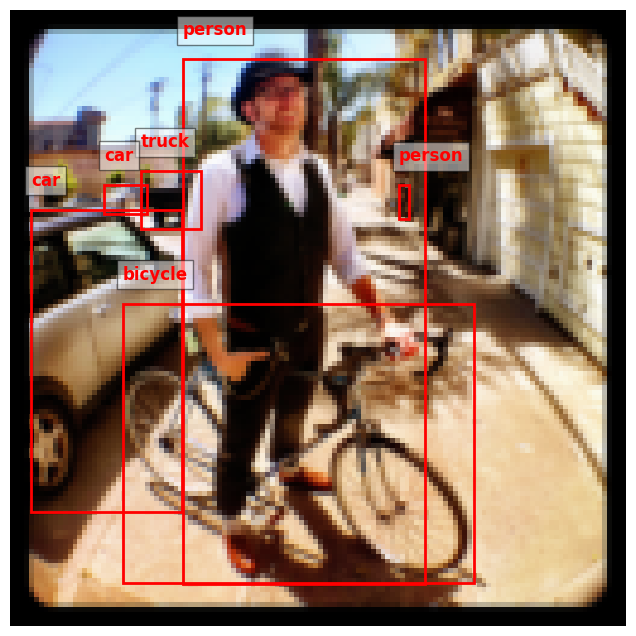

L'immagine contiene 6 oggetti.


In [ ]:
# Test per vedere un elemento del dataset riscalato
img, labels, bboxes = train_dataset[3]

# Ottieni la mappatura delle categorie (category_id -> category_name)
category_id_to_name = {cat["id"]: cat["name"] for cat in coco_train.loadCats(coco_train.getCatIds())}

# Converti labels e bounding boxes in formato utilizzabile
bboxes = [bbox.tolist() for bbox in bboxes]  # Converte i tensori in liste
labels = [int(label.item()) for label in labels]  # Converte i tensori in interi

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img.permute(1, 2, 0))

# Aggiungi bounding box e labels
for bbox, label in zip(bboxes, labels):
    x_min, y_min, x_max, y_max = bbox
    w = x_max - x_min  # Calcola la larghezza
    h = y_max - y_min  # Calcola l'altezza
    class_name = category_id_to_name.get(label, "Unknown")

    # Aggiungi la bounding box
    rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

    # Aggiungi il testo per la label
    ax.text(x_min, y_min - 5, class_name, color='red', fontsize=12, fontweight='bold', bbox=dict(facecolor='white', alpha=0.5))

plt.axis('off')  # Disabilita l'asse
plt.show()

# Mostra il numero di oggetti nell'immagine
print(f"L'immagine contiene {len(annotations)} oggetti.")

In [ ]:
# MODELLO SENZA ADDESTRAMENTO

# Impostare il metodo di avvio del multiprocessing su 'spawn'
mp.set_start_method('spawn', force=True)

# Carica Faster R-CNN pre-addestrato su COCO (senza fine-tuning)
model1 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Imposta il modello in modalità valutazione (inference mode)
model1.eval()

# Sposta su GPU se disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

save_path = "/content/drive/My Drive/faster_rcnn_coco.pth"
torch.save(model1.state_dict(), save_path)

print(f"Modello salvato in {save_path}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 162MB/s]


Modello salvato in /content/drive/My Drive/faster_rcnn_coco.pth


In [ ]:
# MODELLO CON ADDESTRAMENTO

# Impostare il metodo di avvio del multiprocessing su 'spawn'
mp.set_start_method('spawn', force=True)

# Carica il modello pre-addestrato di Faster R-CNN (con ResNet-50 FPN) specificando il tipo di pesi
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Sposta il modello su GPU o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Modalità addestramento
model.train()

# Congelamento di tutti i parametri del backbone (ResNet)
for param in model.backbone.parameters():
    param.requires_grad = False


num_classes = 91  # COCO ha 80 classi + 1 per lo sfondo
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 6  # Sostituisci con il numero di epoche che desideri



Epoch 1/6, Iteration 0, Loss: 5.328739166259766
Epoch 1/6, Iteration 100, Loss: 1.037153959274292
Epoch 1/6, Iteration 200, Loss: 0.9097596406936646
Epoch 1/6, Iteration 300, Loss: 0.7900445461273193
Epoch 1/6, Total Loss: 1.1605698013627852
Epoch 2/6, Iteration 0, Loss: 0.8753682374954224
Epoch 2/6, Iteration 100, Loss: 0.7095961570739746
Epoch 2/6, Iteration 200, Loss: 0.5310778021812439
Epoch 2/6, Iteration 300, Loss: 0.8120759725570679
Epoch 2/6, Total Loss: 0.8497206058051135
Epoch 3/6, Iteration 0, Loss: 0.924781322479248
Epoch 3/6, Iteration 100, Loss: 0.8801816701889038
Epoch 3/6, Iteration 200, Loss: 0.8554918766021729
Epoch 3/6, Iteration 300, Loss: 0.6826022863388062
Epoch 3/6, Total Loss: 0.7807204808737781
Epoch 4/6, Iteration 0, Loss: 0.7903005480766296
Epoch 4/6, Iteration 100, Loss: 0.9701756238937378
Epoch 4/6, Iteration 200, Loss: 0.7424124479293823
Epoch 4/6, Iteration 300, Loss: 0.6130545735359192
Epoch 4/6, Total Loss: 0.7521297241384919
Epoch 5/6, Iteration 0, Los

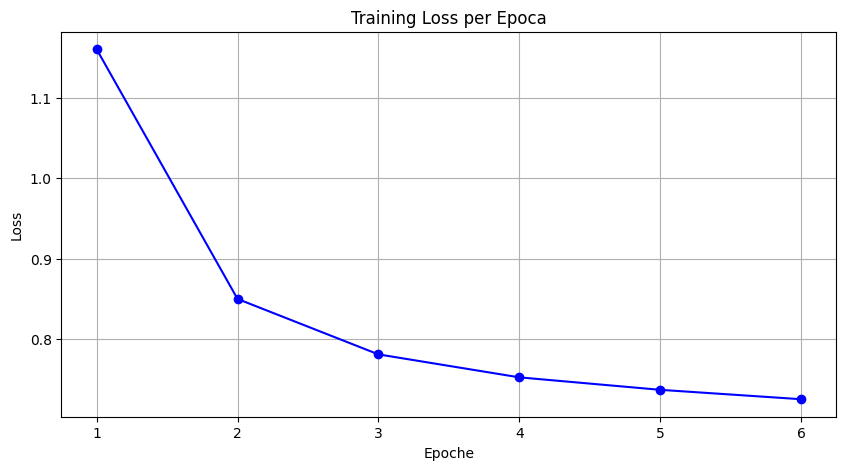

In [ ]:
# Aggiungi il ciclo di addestramento
losses_per_epoch = []  # Per memorizzare la loss per epoca
for epoch in range(num_epochs):
    model.train()  # Modalità addestramento
    model.to(device)
    total_loss = 0  # Inizializza la perdita totale per l'epoca
    for iteration, (images, targets) in enumerate(train_loader):
        # Filtra le immagini con target "boxes" vuoti
        valid_images = []
        valid_targets = []

        for image, target in zip(images, targets):
            # Verifica che i target abbiano almeno un bounding box
            if target["boxes"].shape[0] > 0:  # Solo immagini con oggetti
                valid_images.append(image)
                valid_targets.append(target)

        # Se ci sono immagini valide, esegue l'addestramento
        if valid_images:
            valid_images = [img.to(device) for img in valid_images]
            valid_targets = [{k: v.to(device) for k, v in target.items()} for target in valid_targets]

            # Zero il gradiente, calcola la perdita e ottimizza
            optimizer.zero_grad()
            loss_dict = model(valid_images, valid_targets)
            losses = sum(loss for loss in loss_dict.values())  # Calcola la somma delle perdite

            losses.backward()
            optimizer.step()
            total_loss += losses.item()

        # Stampa la perdita ogni 100 iterazioni
        if iteration % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Iteration {iteration}, Loss: {losses.item()}')

    # Salva la loss media per l'epoca
    epoch_loss = total_loss / len(train_loader)
    losses_per_epoch.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')

# Definisci il percorso di salvataggio nel tuo Drive
save_path = "/content/drive/My Drive/faster_rcnn_trained.pth"

# Salva il modello
torch.save(model.state_dict(), save_path)

print(f"Modello salvato in {save_path}")

# Dopo il training, plottiamo la loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses_per_epoch, marker='o', linestyle='-', color='b')
plt.title("Training Loss per Epoca")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# MODELLO CON ADAM

# Impostare il metodo di avvio del multiprocessing su 'spawn'
mp.set_start_method('spawn', force=True)

# Carica il modello pre-addestrato di Faster R-CNN (con ResNet-50 FPN) specificando il tipo di pesi
model2 = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# Sposta il modello su GPU o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Modalità addestramento
model2.train()

# Congelamento di tutti i parametri del backbone (ResNet)
for param in model.backbone.parameters():
    param.requires_grad = False

num_classes = 91  # COCO ha 80 classi + 1 per lo sfondo
in_features = model2.roi_heads.box_predictor.cls_score.in_features
model2.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

optimizer = optimizer = torch.optim.Adam(model2.parameters(), lr=0.0005)

num_epochs = 6



Epoch 1/6, Iteration 0, Loss: 5.2032036781311035
Epoch 1/6, Iteration 100, Loss: 1.484967589378357
Epoch 1/6, Iteration 200, Loss: 1.2526490688323975
Epoch 1/6, Iteration 300, Loss: 0.8777146339416504
Epoch 1/6, Total Loss: 1.1411319265494475
Epoch 2/6, Iteration 0, Loss: 0.761012852191925
Epoch 2/6, Iteration 100, Loss: 0.9035152196884155
Epoch 2/6, Iteration 200, Loss: 1.0150995254516602
Epoch 2/6, Iteration 300, Loss: 0.9229105114936829
Epoch 2/6, Total Loss: 1.056792248906316
Epoch 3/6, Iteration 0, Loss: 0.9622782468795776
Epoch 3/6, Iteration 100, Loss: 1.0138548612594604
Epoch 3/6, Iteration 200, Loss: 0.9276978373527527
Epoch 3/6, Iteration 300, Loss: 0.9955389499664307
Epoch 3/6, Total Loss: 0.9948964023912276
Epoch 4/6, Iteration 0, Loss: 0.8334792852401733
Epoch 4/6, Iteration 100, Loss: 1.0427922010421753
Epoch 4/6, Iteration 200, Loss: 0.9837685823440552
Epoch 4/6, Iteration 300, Loss: 0.7129806876182556
Epoch 4/6, Total Loss: 0.9467563909453315
Epoch 5/6, Iteration 0, Los

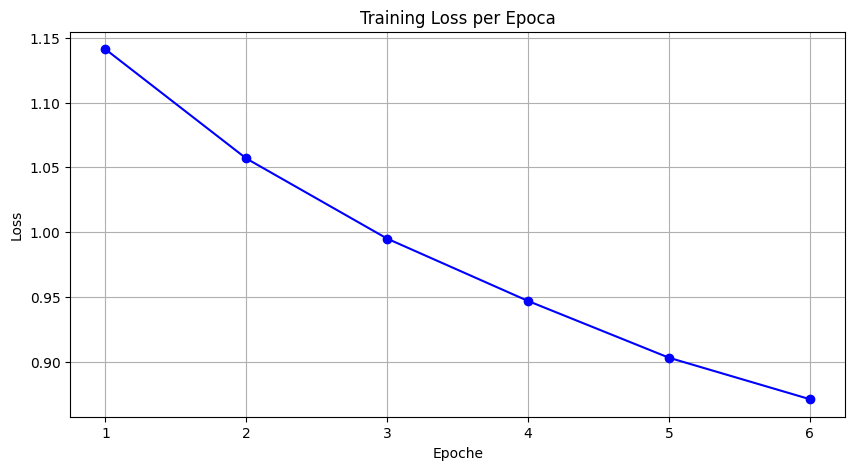

In [ ]:
# ciclo di addestramento
losses_per_epoch = []  # Per memorizzare la loss per epoca
for epoch in range(num_epochs):
    model2.train()  # Modalità addestramento
    model2.to(device)
    total_loss = 0  # Inizializza la perdita totale per l'epoca
    for iteration, (images, targets) in enumerate(train_loader):
        # Filtra le immagini con target "boxes" vuoti
        valid_images = []
        valid_targets = []

        for image, target in zip(images, targets):
            # Verifica che i target abbiano almeno un bounding box
            if target["boxes"].shape[0] > 0:  # Solo immagini con oggetti
                valid_images.append(image)
                valid_targets.append(target)

        # Se ci sono immagini valide, esegue l'addestramento
        if valid_images:
            valid_images = [img.to(device) for img in valid_images]
            valid_targets = [{k: v.to(device) for k, v in target.items()} for target in valid_targets]

            # Zero il gradiente, calcola la perdita e ottimizza
            optimizer.zero_grad()
            loss_dict = model2(valid_images, valid_targets)
            losses = sum(loss for loss in loss_dict.values())  # Calcola la somma delle perdite

            losses.backward()
            optimizer.step()
            total_loss += losses.item()

        # Stampa la perdita ogni 100 iterazioni
        if iteration % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Iteration {iteration}, Loss: {losses.item()}')

    # Salva la loss media per l'epoca
    epoch_loss = total_loss / len(train_loader)
    losses_per_epoch.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')

# Definisci il percorso di salvataggio nel tuo Drive
save_path = "/content/drive/My Drive/faster_rcnn_trained.pth"

# Salva il modello
torch.save(model2.state_dict(), save_path)

print(f"Modello salvato in {save_path}")

# Dopo il training, plottiamo la loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses_per_epoch, marker='o', linestyle='-', color='b')
plt.title("Training Loss per Epoca")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# MODELLO PER MODIFICARE LAYER E DROPOUT
# Load the pretrained Faster R-CNN model
model3 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features for the classifier
in_features = model3.roi_heads.box_predictor.cls_score.in_features

# Modify the classifier head
class CustomClassifier(nn.Sequential):
    def __init__(self, in_features, num_classes):
        super().__init__(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),  # Adding dropout
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  # Adding another dropout layer
            nn.Linear(512, num_classes)
        )

# Modify the regressor head (bounding box predictor)
class CustomRegressor(nn.Sequential):
    def __init__(self, in_features, num_boxes):
        super().__init__(
            nn.Linear(in_features, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_boxes)
        )

# Replace the classifier and regressor in ROI heads
num_classes = 91  # COCO dataset has 91 classes
model3.roi_heads.box_predictor.cls_score = CustomClassifier(in_features, num_classes)
model3.roi_heads.box_predictor.bbox_pred = CustomRegressor(in_features, num_boxes=4)

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device)

# Print model summary to verify modifications
print(model3)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
optimizer = torch.optim.SGD(model3.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 6

Epoch 1/6, Iteration 0, Loss: 5.1677422523498535
Epoch 1/6, Iteration 100, Loss: 1.6032253503799438
Epoch 1/6, Iteration 200, Loss: 1.293521761894226
Epoch 1/6, Iteration 300, Loss: 1.5266609191894531
Epoch 1/6, Total Loss: 1.3634004396361274
Epoch 2/6, Iteration 0, Loss: 1.0703487396240234
Epoch 2/6, Iteration 100, Loss: 1.12641179561615
Epoch 2/6, Iteration 200, Loss: 0.8910894989967346
Epoch 2/6, Iteration 300, Loss: 0.9501687288284302
Epoch 2/6, Total Loss: 1.0935435022856739
Epoch 3/6, Iteration 0, Loss: 1.0000869035720825
Epoch 3/6, Iteration 100, Loss: 0.7984893321990967
Epoch 3/6, Iteration 200, Loss: 0.7761645913124084
Epoch 3/6, Iteration 300, Loss: 0.8278083205223083
Epoch 3/6, Total Loss: 0.9020908149513038
Epoch 4/6, Iteration 0, Loss: 0.6319511532783508
Epoch 4/6, Iteration 100, Loss: 0.9243749976158142
Epoch 4/6, Iteration 200, Loss: 0.5599051117897034
Epoch 4/6, Iteration 300, Loss: 0.8591218590736389
Epoch 4/6, Total Loss: 0.7689878130281294
Epoch 5/6, Iteration 0, Los

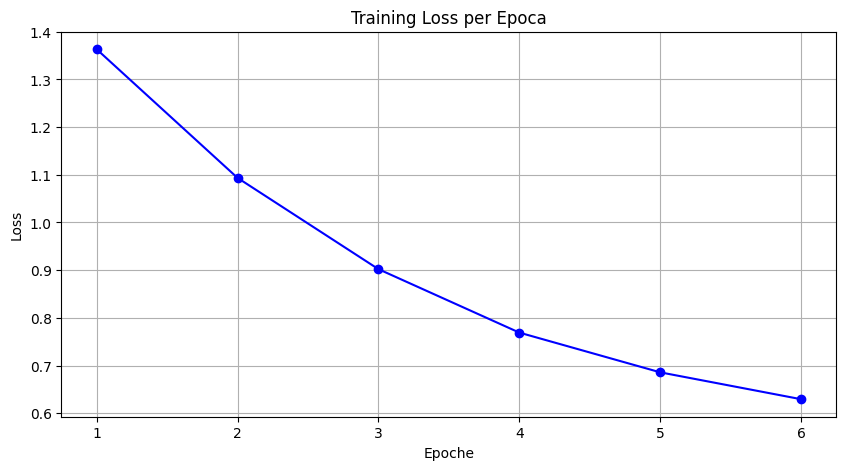

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.to(device)
# Aggiungi il ciclo di addestramento
losses_per_epoch = []  # Per memorizzare la loss per epoca
for epoch in range(num_epochs):
    model3.train()  # Modalità addestramento
    total_loss = 0  # Inizializza la perdita totale per l'epoca
    for iteration, (images, targets) in enumerate(train_loader):
        # Filtra le immagini con target "boxes" vuoti
        valid_images = []
        valid_targets = []

        for image, target in zip(images, targets):
            # Verifica che i target abbiano almeno un bounding box
            if target["boxes"].shape[0] > 0:  # Solo immagini con oggetti
                valid_images.append(image)
                valid_targets.append(target)

        # Se ci sono immagini valide, esegui l'addestramento
        if valid_images:
            valid_images = [img.to(device) for img in valid_images]
            valid_targets = [{k: v.to(device) for k, v in target.items()} for target in valid_targets]

            # Zero il gradiente, calcola la perdita e ottimizza
            optimizer.zero_grad()
            loss_dict = model3(valid_images, valid_targets)
            losses = sum(loss for loss in loss_dict.values())  # Calcola la somma delle perdite

            losses.backward()
            optimizer.step()
            total_loss += losses.item()

        # Stampa la perdita ogni 100 iterazioni
        if iteration % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Iteration {iteration}, Loss: {losses.item()}')

    # Salva la loss media per l'epoca
    epoch_loss = total_loss / len(train_loader)
    losses_per_epoch.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{num_epochs}, Total Loss: {epoch_loss}')

# Definisci il percorso di salvataggio nel tuo Drive
save_path = "/content/drive/My Drive/faster_rcnn_new.pth"

# Salva il modello
torch.save(model3.state_dict(), save_path)

print(f"Modello salvato in {save_path}")

# Dopo il training, plottiamo la loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses_per_epoch, marker='o', linestyle='-', color='b')
plt.title("Training Loss per Epoca")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
#PERFORMANCE
# Funzione per calcolare gli FPS
def compute_fps(model, data_loader, device):
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            _ = model(images)
    end_time = time.time()
    total_time = end_time - start_time
    fps = len(data_loader.dataset) / total_time  # Calcola FPS
    return fps

# Funzione per calcolare il mAP
def compute_map(model, data_loader, device):
    model.eval()
    metric = MeanAveragePrecision()
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)
            metric.update(outputs, targets)
    mAP = metric.compute()
    return mAP['map']

# Simuliamo tre configurazioni di modelli
configs = {
    "Original": model1,
    "With training": model,
    "Adam": model2,
    "Different layer and dropout": model3
}

# Creiamo un data loader per il dataset di test
test_loader = val_loader

# Eseguiamo i calcoli per ogni configurazione
results = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for label, model in configs.items():
    model.to(device)

    # Calcolare mAP
    mAP = compute_map(model, test_loader, device)

    # Calcolare FPS
    fps = compute_fps(model, test_loader, device)

    results[label] = {
        'mAP': mAP,
        'FPS': fps
    }

# Stampiamo i risultati
print("Performance Summary:")
print("{:<40} {:<10} {:<10}".format("Model", "mAP (%)", "FPS"))
for label, metrics in results.items():
    print("{:<40} {:<10.2f} {:<10.2f}".format(label, metrics['mAP'] * 100, metrics['FPS']))
